<a href="https://colab.research.google.com/github/bokoo/pytorch-stem-sep/blob/main/WaveUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
from torch import nn
import torch.nn.functional as F
import torchaudio
import os
import random
from torchsummary import summary
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import time
import gc

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_path = '/content/drive/MyDrive/ML_data/data'
train_path = base_path + "/train"
val_path = base_path + "/val"
test_path = base_path + "/test"

In [ ]:
class MusDB18MiniMono(Dataset):

    def __init__(self, audio_dir, bit_rate = 44100):
        all_subdirectories = os.listdir(audio_dir)
        num_of_subdirectories = len(all_subdirectories)
        self.mix_samples = torch.zeros((num_of_subdirectories * 7, bit_rate))
        self.bass_targets = torch.zeros((num_of_subdirectories * 7, bit_rate))
        self.drums_targets = torch.zeros((num_of_subdirectories * 7, bit_rate))
        self.vocals_targets = torch.zeros((num_of_subdirectories * 7, bit_rate))
        self.other_targets = torch.zeros((num_of_subdirectories * 7, bit_rate))
        i = 0
        for dir in all_subdirectories:
            mix = self._stereo_to_mono_convertor(torchaudio.load(audio_dir + '/' + dir + '/mixture.wav'))
            bass = self._stereo_to_mono_convertor(torchaudio.load(audio_dir + '/' + dir + '/bass.wav'))
            drums = self._stereo_to_mono_convertor(torchaudio.load(audio_dir + '/' + dir + '/drums.wav'))
            vocals = self._stereo_to_mono_convertor(torchaudio.load(audio_dir + '/' + dir + '/vocals.wav'))
            other = self._stereo_to_mono_convertor(torchaudio.load(audio_dir + '/' + dir + '/other.wav'))
            for j in range(7):
                self.mix_samples[i] = mix[j * bit_rate : (j + 1) * bit_rate]
                self.bass_targets[i] = bass[j * bit_rate : (j + 1) * bit_rate]
                self.drums_targets[i] = drums[j * bit_rate : (j + 1) * bit_rate]
                self.vocals_targets[i] = vocals[j * bit_rate : (j + 1) * bit_rate]
                self.other_targets[i] = other[j * bit_rate : (j + 1) * bit_rate]
                i += 1

    def __len__(self):
        return len(self.mix_samples)

    def __getitem__(self, index):
        mix = self.mix_samples[index]
        mix = mix.unsqueeze(0)
        bass = self.bass_targets[index]
        drums = self.drums_targets[index]
        vocals = self.vocals_targets[index]
        other = self.other_targets[index]
        targets = torch.stack([bass, drums, vocals, other], dim=0)
        return mix, targets

    def _stereo_to_mono_convertor(self, signal):
        # If there is more than 1 channel in your audio
        if signal[0].shape[0] > 1:
            # Do a mean of all channels and keep it in one channel
            signal = torch.mean(signal[0], dim=0, keepdim=False)
        return signal

In [ ]:
train_dataset = MusDB18MiniMono(train_path)
val_dataset = MusDB18MiniMono(val_path)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5, stride=1, padding='same'):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2.0, mode='linear', align_corners=True)
        return self.conv(x)

class WaveUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, features=[64, 128, 256, 512], pool_kernel_size=4, pool_stride=4):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool1d(kernel_size=pool_kernel_size, stride=pool_stride)

        #Downsampling part
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature, kernel_size=15))
            in_channels=feature

        #Up part
        for feature in reversed(features):
            self.ups.append(UpSample(feature*2, feature))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        x = self.final_conv(x)
        x = self.tanh(x)

        return x

In [ ]:
def train_one_epoch(model, data_loader, loss_fn, optimizer, device):
    epoch_loss = 0.0
    for i, (mix, targets) in enumerate(data_loader):
        print(f"processing batch {i} of {len(data_loader)}")
        mix, targets = mix.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(mix)
        loss = get_loss(loss_fn, outputs, targets, mix)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss

def get_loss(loss_fn, outputs, targets, mix):
    outputs = outputs.view((targets.size()[0], targets.size()[1] - 1, targets.size()[2]))
    # Take the last output as "other" by subtracting the 3 predicted stems from the original mixture
    last_output = mix - torch.sum(outputs, 1, keepdim=True)
    all_outputs = torch.cat((outputs, last_output), 1)
    return loss_fn(all_outputs, targets)

def get_validation_loss(model, data_loader, loss_fn, device):
    total_val_loss = 0.0
    with torch.no_grad():
      for i, (mix, targets) in enumerate(data_loader):
          mix, targets = mix.to(device), targets.to(device)
          outputs = model(mix)
          loss = get_loss(loss_fn, outputs, targets, mix)
          total_val_loss += loss.item()
    return total_val_loss

def train(model, train_data_loader, val_data_loader, loss_fn, optimizer, device, num_epochs):
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        loss = train_one_epoch(model, train_data_loader, loss_fn, optimizer, device)
        train_loss.append(loss)
        print(f"Epoch: {epoch} -> loss: {loss} || Epoch took {time.time() - start_time} seconds.")
        model.eval()
        val_loss.append(get_validation_loss(model, val_data_loader, loss_fn, device))
    return train_loss, val_loss

In [ ]:
def stereo_to_mono_convertor(signal):
    # If there is more than 1 channel in your audio
    if signal[0].shape[0] > 1:
        # Do a mean of all channels and keep it in one channel
        signal = torch.mean(signal[0], dim=0, keepdim=False)
    return signal

def split_song(path, model, output_path, device):
    sample_rate = 44100
    mix = torchaudio.load(path)
    mix = stereo_to_mono_convertor(mix)

    number_of_segments = len(mix) // sample_rate
    if len(mix) % sample_rate != 0:
        number_of_segments += 1;

    bass = []
    drums = []
    vocals = []
    other = []
    model.eval()
    with torch.no_grad():
        for i in range(number_of_segments):
            chunk = mix[i * sample_rate : (i + 1) * sample_rate]
            chunk = chunk.view(1, 1, 44100).to(device)
            targets = model(chunk)
            targets = targets.view((3, 44100)).cpu()
            bass.append(targets[0])
            drums.append(targets[1])
            vocals.append(targets[2])
            other.append(chunk.view(1, 44100)[0].cpu() - torch.sum(targets, 0, keepdim=False))

    # Concatenate all the chunks to form complete stems
    bass_track = torch.cat(bass, dim=0)
    drums_track = torch.cat(drums, dim=0)
    vocals_track = torch.cat(vocals, dim=0)
    other_track = torch.cat(other, dim=0)

    torchaudio.save(output_path + '_bass.wav', bass_track.unsqueeze(0), sample_rate)
    torchaudio.save(output_path + '_drums.wav', drums_track.unsqueeze(0), sample_rate)
    torchaudio.save(output_path + '_vocals.wav', vocals_track.unsqueeze(0), sample_rate)
    torchaudio.save(output_path + '_other.wav', other_track.unsqueeze(0), sample_rate)

In [ ]:
model = WaveUNet(features=[64, 128, 256, 512]).to(device)
summary(model, (1, 44100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 64, 44100]             960
       BatchNorm1d-2            [-1, 64, 44100]             128
              ReLU-3            [-1, 64, 44100]               0
            Conv1d-4            [-1, 64, 44100]          61,440
       BatchNorm1d-5            [-1, 64, 44100]             128
              ReLU-6            [-1, 64, 44100]               0
        DoubleConv-7            [-1, 64, 44100]               0
         MaxPool1d-8            [-1, 64, 11025]               0
            Conv1d-9           [-1, 128, 11025]         122,880
      BatchNorm1d-10           [-1, 128, 11025]             256
             ReLU-11           [-1, 128, 11025]               0
           Conv1d-12           [-1, 128, 11025]         245,760
      BatchNorm1d-13           [-1, 128, 11025]             256
             ReLU-14           [-1, 128

In [ ]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
with torch.no_grad():
  torch.cuda.empty_cache() # PyTorch thing
gc.collect() # Python thing

17

In [ ]:
history = train(model, train_loader, val_loader, loss_fn, optimizer, device, 20)

processing batch 0 of 21
processing batch 1 of 21
processing batch 2 of 21
processing batch 3 of 21
processing batch 4 of 21
processing batch 5 of 21
processing batch 6 of 21
processing batch 7 of 21
processing batch 8 of 21
processing batch 9 of 21
processing batch 10 of 21
processing batch 11 of 21
processing batch 12 of 21
processing batch 13 of 21
processing batch 14 of 21
processing batch 15 of 21
processing batch 16 of 21
processing batch 17 of 21
processing batch 18 of 21
processing batch 19 of 21
processing batch 20 of 21
Epoch: 0 -> loss: 0.06001239432953298 || Epoch took 30.035797595977783 seconds.
processing batch 0 of 21
processing batch 1 of 21
processing batch 2 of 21
processing batch 3 of 21
processing batch 4 of 21
processing batch 5 of 21
processing batch 6 of 21
processing batch 7 of 21
processing batch 8 of 21
processing batch 9 of 21
processing batch 10 of 21
processing batch 11 of 21
processing batch 12 of 21
processing batch 13 of 21
processing batch 14 of 21
proc

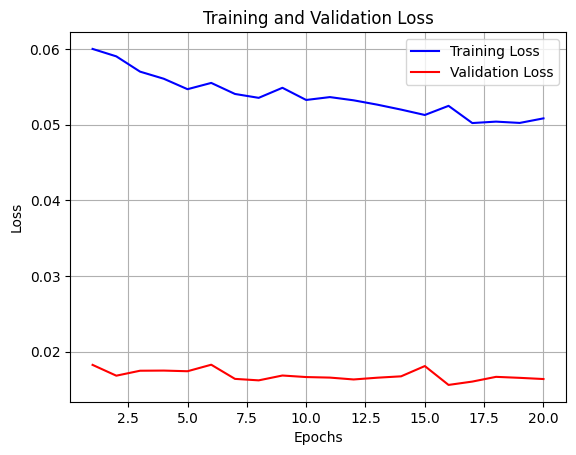

In [ ]:
epochs = range(1, len(history[0]) + 1)

plt.plot(epochs, history[0], 'b', label='Training Loss')
plt.plot(epochs, history[1], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
split_song("/content/drive/MyDrive/ML_data/data/train/Angela Thomas Wade - Milk Cow Blues/mixture.wav", model, "/content/drive/MyDrive/ML_data/data/testo30", device)

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/ML_data/model")